<a href="https://colab.research.google.com/github/mehdihatami1998/DynamicsOfStructures/blob/main/L13_Numerical_Stability_Integration_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Stability of Integration Algorithms

Let's start importing some libraries and defining an helper function.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, inv

def plot(t, x, title, labels=None, **kwd):
    lines = plt.plot(t, x, **kwd)
    if labels: plt.legend(lines, labels)
    plt.title(title)
    plt.xlabel('$t\,/$s')
    plt.grid()

### Choose what to do next…

The code line below can be `stable = True` or `stable = False` (note the capitalization), you should toggle the value to see what happens with the Linear Accelerarion algorithm.

In [ ]:
stable = False


### Structural Matrices
Depending on the value of `stable` the bottom storey stiffness is changed, leading to $\omega_5>2\sqrt3\,/\,h$ when `stable = False`.

In [ ]:
N = 5
kk = [0, 10, 10, 10, 10, 1100 if stable else 1300]
K  = np.diag([a+b for a, b in zip(kk, kk[1:])]) 
K += np.diag([-a for a in kk[1:-1]], 1)
K += np.diag([-a for a in kk[1:-1]], -1)
M = np.eye(N)

### Loading

The loading is $$\mathbf p = \begin{Bmatrix}1\\0\\0\\0\\0\end{Bmatrix}\,\sin\omega_0t,\text{ with }\omega_0 = 1.$$

In [ ]:
w0 = 1.0
r = np.zeros(N) ; r[0] = 1.0
t = np.linspace(0, 12, 121)
h = 0.100
f_t = np.sin(w0*t)
p_t = np.outer(f_t, r)

### Analytical Solution, via Modal Analysis

max ω when h = 0.1s is 2*sqrt(3)/h = 34.641 rad/s
and these are the modal frequencies...


array([ 1.09642881,  3.15821053,  4.84143475,  5.94193069, 36.19499302])

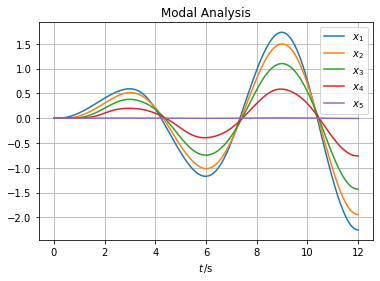

In [ ]:
evl, evc = eigh(K, M)
wn = np.sqrt(evl)
# NB because eigh returns NORMALIZED ψ's, M_star is the unit matrix
#    hence G = Mstar¯¹ Ψt r is simply
G = evc.T@r
# ξ(t) = c sin ω₀t, 
c = inv(np.diag(wn**2)-w0**2*np.eye(N))@G
# starting from rest conditions, f[:,None] has an additional dimension, it's 5×1
q_j = c*(f_t[:,None]-w0/wn*np.sin(np.outer(t, wn))) # q_i is n×j, n=121, j=5
x_i = np.einsum('ij,nj->ni', evc, q_j)            # x_i is n×i, n=121, i=5

plot(t, x_i, 'Modal Analysis', '$x_1$ $x_2$ $x_3$ $x_4$ $x_5$'.split())

print('max ω when h = 0.1s is 2*sqrt(3)/h = 34.641 rad/s')
print('and these are the modal frequencies...')
wn

### Numerical Solution, Constant Acceleration Algorithm

The CAA is unconditionally stable.

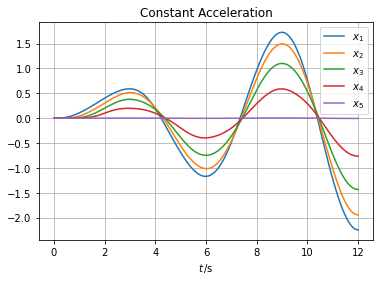

In [ ]:
x0, v0 = np.zeros(N), np.zeros(N)
K_ = K + 4*M/h**2
F_ = inv(K_)
X = []
for p0, p1 in zip(p_t, p_t[1:]):
    X.append(x0)
    a0 = inv(M)@(p0-K@x0)
    dp = (p1-p0)+M@(2*a0+4*v0/h)
    dx = F_@dp
    dv = 2*dx/h - 2*v0 # - a0*h/2
    x0 = x0+dx
    v0 = v0+dv
X.append(x0)
X = np.array(X)

plot(t[:], X[:], 'Constant Acceleration',
     '$x_1$ $x_2$ $x_3$ $x_4$ $x_5$'.split())

### Numerical Solution, Linear Acceleration Algorithm

If $\omega_5<34.641$ rad/s, no problem, otherwise we have numerical instability.

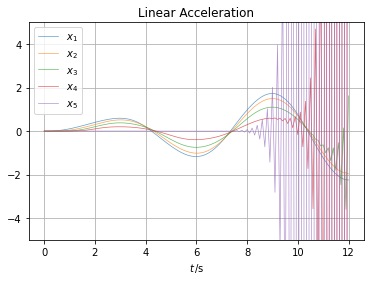

In [ ]:
x0, v0 = np.zeros(N), np.zeros(N)
K_ = K + 6*M/h**2
F_ = inv(K_)

X = []
for p0, p1 in zip(p_t, p_t[1:]):
    X.append(x0)
    a0 = inv(M)@(p0-K@x0)
    dp = (p1-p0)+M@(3*a0+6*v0/h)
    dx = F_@dp
    dv = 3*dx/h - 3*v0 - a0*h/2
    x0 = x0+dx
    v0 = v0+dv
X.append(x0)
X = np.array(X)

if stable:
    plot(t[:], X[:], 'Linear Acceleration',
         '$x_1$ $x_2$ $x_3$ $x_4$ $x_5$'.split())
else:
    plot(t[:], X[:], 'Linear Acceleration',
         '$x_1$ $x_2$ $x_3$ $x_4$ $x_5$'.split(),
         lw=0.7, alpha=0.7)
    plt.ylim((-5, 5)) ;

If `stable = False`, you should note that the instability starts in $x_5$, but after a while it is shown also in $x_4$ and in $x_3$.
### Numerical Solution, Wilson's θ Method

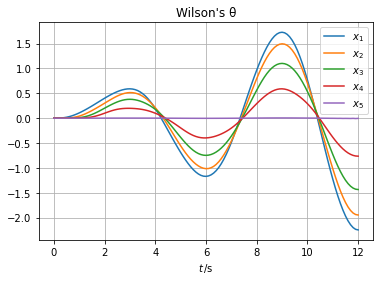

In [ ]:
θ = 1.42
h_hat = h*θ

x0, v0 = np.zeros(N), np.zeros(N)
F_hat = inv(K + 6*M/h_hat**2)
X = []
for p0, p1 in zip(p_t, p_t[1:]):
    X.append(x0)
    a0 = inv(M)@(p0-K@x0)
    dp_hat = θ*(p1-p0)+M@(3*a0+6*v0/h_hat)
    dx_hat = F_hat@dp_hat
    da = (6*dx_hat/h_hat**2 - 6*v0/h_hat - 3*a0)/θ
    x0 = x0 + v0*h + a0*h**2/2 + da*h**2/6
    v0 = v0 + a0*h + da*h/2
X.append(x0)
X = np.array(X)

plot(t[:], X[:], "Wilson's θ",
     '$x_1$ $x_2$ $x_3$ $x_4$ $x_5$'.split())